In [2]:
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, norm, shapiro
import os
from itertools import combinations
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from scipy import ndimage
import glob
import json
from IPython.display import clear_output

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

## In this notebook we are going to take a general survey of all the QuadGraphs created

In [3]:
chroms= ['chr'+str(x) for x in range(1, 23)] + ['chrX', 'chrY']
bed = []
data = {
    'nodes': [],
    'edges': [],
    'quads': [],
    'endPos': [],
    'beginPos': [],
    'strands': [],
    'chroms': [],
    'ghostBeginPos': []
}
for strand in ['positive', 'negative']:
    s = '+' if strand == 'positive' else '-'
    data_dir = '../data/chrom_wise_graph_summary/%s' % strand
    for chrom in chroms:
        d = json.load(open('%s/%s.json' % (data_dir, chrom)))
        d['strands'] = [s for x in range(len(d['nodes']))]
        d['chroms'] = [chrom for x in range(len(d['nodes']))]
        for i in d:
            data[i].extend(d[i])

In [4]:
data.keys()

dict_keys(['beginPos', 'strands', 'nodes', 'edges', 'ghostBeginPos', 'chroms', 'endPos', 'quads'])

In [5]:
nodes = np.array(data['nodes'])
edges = np.array(data['edges'])
data['spans'] = np.array(data['endPos']) - np.array(data['beginPos'])
data['graph_density'] = (2*edges)/(nodes * (nodes-1))
data['node_density'] = nodes/data['spans']
data['score'] = np.array(data['node_density']) + np.array(data['graph_density'])

In [6]:
len(data['nodes']), sum(data['nodes']), sum(data['edges']), sum(data['quads']), sum(data['spans'])

(5858234, 200097266, 2010711252, 433579218942, 994118624)

In [7]:
max(data['nodes']), max(data['edges']), max(data['quads']), max(data['spans'])

(18438, 475937, 1476614909, 50853)

In [8]:
min(data['nodes']), min(data['edges']), min(data['quads']), min(data['spans'])

(4, 3, 1, 14)

In [9]:
np.mean(data['nodes']), np.mean(data['edges']), np.mean(data['quads']), np.mean(data['spans'])

(34.156584731849222,
 343.22822406889173,
 74011.932425710547,
 169.69595683613866)

In [10]:
np.median(data['nodes']), np.median(data['edges']), np.median(data['quads']), np.median(data['spans'])

(20.0, 75.0, 293.0, 123.0)

In [11]:
len(np.where(np.array(data['quads']) == 1)[0])

87200

In [12]:
len(np.where(np.array(data['quads']) > 10)[0])

4976817

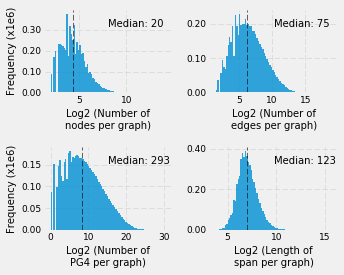

In [59]:
plt.style.use('fivethirtyeight')

from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    return '%1.2f' % (x*1e-6)
formatter = FuncFormatter(millions)

keys = ['nodes', 'edges', 'quads', 'spans', 'graph_density', 'node_density']
loc = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
labels = ['Number of\nnodes per graph', 'Number of\nedges per graph', 'Number of\nPG4 per graph',
          'Length of\nspan per graph', 'Density of\neach graph', 'Node\ndensity per graph']
fig, axis = plt.subplots(2, 2, figsize=(5,4))
for i in range(4):
    ax = axis[loc[i]]
    ax.hist(np.log2(data[keys[i]]), bins=80, edgecolor='none',
            alpha=0.8)
    median = np.median(data[keys[i]])
    ax.axvline(np.log2(median), lw=1, ls='--', color='k', alpha=0.6)
    if loc[i][1] == 0:
        ax.set_ylabel('Frequency (x1e6)', fontsize=10)
    ax.set_xlabel('Log2 (%s)' % labels[i], fontsize=10)
    ax.yaxis.set_major_formatter(formatter)
    ax.text(0.5, 0.8, "Median: %d" % median, fontsize=10, transform=ax.transAxes)
    clean_axis(ax)

fig.tight_layout()
plt.savefig('../images/properties_distribution.svg', transparent=True, edgecolor='none')
plt.savefig('../images/properties_distribution.png', dpi=300, transparent=True, edgecolor='none')
plt.show()

In [31]:
out_handles = {chrom: open('./data/QuadGraphs_bed/%s.bed' % chrom, 'w')
               for chrom in chroms}

for i in tqdm(range(len(data['nodes']))):
    bed_line = [data['chroms'][i], data['beginPos'][i], data['endPos'][i] + 1,
                data['ghostBeginPos'][i], data['score'][i], data['strands'][i]]
    out_handles[data['chroms'][i]].write("\t".join(map(str, bed_line)) + '\n')
    
for i in out_handles:
    out_handles[i].close()

100%|██████████| 5858234/5858234 [00:56<00:00, 102930.66it/s]


In [ ]:
!cat QuadGraphs_bed/* | sort -k 1,1 -k2n,2 > QuadGraph.bed

### Now we will see the distribution of loops and bulge lengths in the QuadGraphs. The distributions were precalculated using the script: QG_all_loop_len_calc.py

In [13]:
loop_dir = "../data/quad_graph_loop_profile"
chroms = ['chr%d' % i for i in range(1, 23)] + ['chrX', 'chrY']
strands = ["positive", 'negative']
keys = [
        "0_0", "0_1", "0_2", "0_3",
        "1_0", "1_1", "1_2", "1_3",
        "2_0", "2_1", "2_2", "2_3",
        "3_0", "3_1", "3_2", "3_3",
    ]
loop_data = {str(x): [] for x in range(1, 51)}
bulge_data = {'0': [], '1': [], '2': [], '3': []}
for chrom in chroms:
    fns = sorted(glob.glob("%s/%s/*/*.json" % (loop_dir, chrom)))
    for fn in tqdm(fns, desc=chrom):
        d = json.load(open(fn))
        temp = {str(x): 0 for x in range(1, 51)}
        for k in d[0]:
            for l in d[0][k]:
                temp[l]+=d[0][k][l]
        for l in temp:
            loop_data[l].append(temp[l])
        for k in d[1]:
            bulge_data[k].append(d[1][k])
    clear_output()

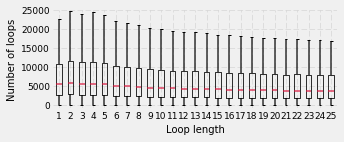

In [14]:
boxprops = dict(linestyle='-', linewidth=1, color='k', alpha=0.8)
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson', alpha=0.8)
whiskerprops = dict(linestyle='-', linewidth=1.5, color='k', alpha=0.8)

for_box = []
for i in range(1, 26):
    for_box.append(np.array(loop_data[str(i)]))
fig, ax = plt.subplots(1, 1, figsize=(5,2.2))
ax.boxplot(for_box, sym='', boxprops=boxprops,
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_xlabel('Loop length', fontsize=10)
ax.set_ylabel('Number of loops', fontsize=10)
ax.set_yticks([x for x in range(0, 30000, 5000)])
ax.set_ylim((-1000, 25001))
clean_axis(ax)
plt.tight_layout()

plt.savefig('../images/quadgraph_loop_dists.svg', transparent=True, edgecolor='none')
plt.savefig('../images/quadgraph_loop_dists.png', dpi=300, transparent=True, edgecolor='none')
plt.show()

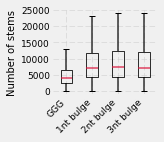

In [15]:
boxprops = dict(linestyle='-', linewidth=1, color='k', alpha=0.8)
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson', alpha=0.8)
whiskerprops = dict(linestyle='-', linewidth=1.5, color='k', alpha=0.8)

for_box = []
for i in range(0, 4):
    for_box.append(np.array(bulge_data[str(i)]))

fig, ax = plt.subplots(1, 1, figsize=(2.5,2.2))
ax.boxplot(for_box, sym='', boxprops=boxprops,
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylabel('Number of stems', fontsize=10)
ax.set_yticks([x for x in range(0, 30000, 5000)])
ax.set_ylim((-1000, 25001))
ax.set_xticklabels(['GGG', '1nt bulge', '2nt bulge', '3nt bulge'],
                      rotation=45, ha='right', va='top', fontsize=12)
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/quadgraph_bulges.svg', transparent=True, edgecolor='none')
plt.savefig('../images/quadgraph_bulges.png', dpi=300, transparent=True, edgecolor='none')
plt.show()